In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from random import shuffle

df = pd.read_csv('train.tsv', sep='\t')

train_size = 0.8
data_size = 10000

df = df[:data_size]
train = df[:int(data_size*0.8)].sample(frac=1)
dev = df[int(data_size*0.8):].sample(frac=1).reset_index()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [2]:
#TODO : prétraitements
#StopList, integer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
text_data = train["Phrase"]
vectorizer.fit(text_data)
voca = vectorizer.get_feature_names()


In [4]:
%%time

word2index = {i:w for w,i in enumerate(voca)}

def s2v(ohvS, pad):    
    y = torch.tensor(ohvS).unsqueeze(1)
    onehot = torch.zeros(len(y), len(voca))
#     Prend en compte les phrases n'ayant que des mots non présents dans le voca ('the')
# devrait être géré après prétraitrements
    if len(ohvS) > 0:
        onehot.scatter_(1, y, 1)
    paddingT = torch.zeros(1, len(voca))
    for i in range(len(ohvS), pad):
        onehot = torch.cat((onehot, paddingT), 0)
    return onehot
    
def sentence2index(sent, voca, dic):
    return [dic[w] for w in set(sent.split()).intersection(voca)]

train_data = text_data.apply(lambda x : sentence2index(x, voca, word2index))
longestSentence = train_data.apply(lambda x : len(x)).max()
text_tensor_train = train_data.apply(lambda x : s2v(x, longestSentence))

#ajout du cas où on ne connait pas le mot
# voca = vectorizer.get_feature_names() + list(['<unk>'])
#ajout d'un zéro à la fin de chaque tensor
# unk = torch.zeros([text_tensor_train.shape[0],1], dtype=torch.float)
# text_tensor_train = torch.cat((text_tensor_train, unk), 1).unsqueeze(1)

def labelToVec(label):
    # label_one_hot_vector = torch.tensor(pd.get_dummies(df["Sentiment"]).values)
    label_tensor = torch.tensor(label["Sentiment"].values)
    return label_tensor

label_tensor_train = labelToVec(train)

CPU times: user 2.24 s, sys: 613 ms, total: 2.86 s
Wall time: 2.85 s


In [5]:
#Ne prend pas en compte <unk>

dev_data = dev['Phrase'].apply(lambda x : sentence2index(x, voca, word2index))
text_tensor_dev = dev_data.apply(lambda x : s2v(x, longestSentence))

label_tensor_dev = labelToVec(dev)

print(type(text_tensor_dev))

<class 'pandas.core.series.Series'>


In [6]:
#DF to tensor

text_tensor_train = torch.cat(([t.unsqueeze(0) for t in text_tensor_train]), 0)
text_tensor_dev = torch.cat(([t.unsqueeze(0) for t in text_tensor_dev]), 0)


In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, embedding_size)

        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.h2o = nn.Linear(hidden_size, output_size)       
        
    def forward(self, input):
        
        hidden = self.initHidden(input.shape[0]).to(device)        
        output, hidden = self.rnn(input, hidden)
        output = self.h2o(hidden[0])
        
        return output

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, dtype=torch.float)

In [11]:
import numpy as np

input_dim = len(voca)
embedding_size = 100
hidden_dim = 128
output_dim = 5

rnn = RNN(input_dim, embedding_size, hidden_dim, output_dim)

rnn = rnn.to(device)

import torch.optim as optim

optimizer = optim.Adadelta(rnn.parameters(), lr=0.1)

def trainRNN(train_category, train_text, dev_category, dev_text, num_epoch, batch_size):
    
    print(len(voca))
    print(train_text.shape)
    #un jour je ferais un truc propre
    size_train = train_text.size(0)
    size_dev = dev_text.size(0)
    
    hidden = rnn.initHidden(batch_size) 
    
    #TODO vecteur de poids (ici approche "naïve")
    weight = torch.tensor([1, 0.23, 0.07, 0.2, 0.76])
    criterion = nn.CrossEntropyLoss(weight=weight)
    
    total_pred = torch.tensor([], dtype = torch.long).to(device)
    total_targ = torch.tensor([], dtype = torch.long).to(device)
    
    train_loss = np.zeros(num_epoch)
    train_acc = np.zeros(num_epoch)
    dev_loss = np.zeros(num_epoch)
    dev_acc = np.zeros(num_epoch)
 
    for epoch in range(num_epoch):
        nb_batch_train = len(train_text) / batch_size
        nb_batch_dev = len(dev_text) / batch_size

        i = 0
        while (i + batch_size) <= size_train:
            tmp = i
            i += batch_size
            input = train_text[tmp:i].to(device)
            target = train_category[tmp:i].to(device)
            output = rnn(input)      
            
            # ?
            optimizer.zero_grad()
            loss = criterion(output.squeeze(0), target)
            loss.backward()
            
            #TODO Tester sans
#             torch.nn.utils.clip_grad_norm_(rnn.parameters(),0.5)
            optimizer.step() 
            
            predicted = torch.argmax(output.data, dim=1)
            correct = (predicted == target).sum().item()
            
            train_loss[epoch]  += loss.item()
            train_acc[epoch] += correct / batch_size
        
        i = 0        
        #j'aime faire des boucles presque pareilles
        while (i + batch_size) <= size_dev:
            tmp = i
            i += batch_size
            input = dev_text[tmp:i].to(device)
            target = dev_category[tmp:i].to(device)
            
            output = rnn(input)
            loss = criterion(output.squeeze(0), target)   
            
            predicted = torch.argmax(output.data, dim=1)
            correct = (predicted == target).sum().item()
            
            dev_loss[epoch] += loss.item()
            dev_acc[epoch] += correct / batch_size
            
            #dernière epoch
            if epoch + 1 == num_epoch:
                total_pred = torch.cat((total_pred, predicted), 0)
                total_targ = torch.cat((total_targ, target), 0)
        
        # keep best rnn (if acc_act > best_act then best_rnn = actual_rnn)
        
        train_loss[epoch] = train_loss[epoch] / nb_batch_train
        train_acc[epoch] = train_acc[epoch] / nb_batch_train
        dev_loss[epoch] = dev_loss[epoch] / nb_batch_dev
        dev_acc[epoch] = dev_acc[epoch] / nb_batch_dev
 
        print(epoch, "loss :", train_loss[epoch], "/ acc :", train_acc[epoch])
        print("Dev loss :", dev_loss[epoch], "/ acc :", dev_acc[epoch])
        
    print('Fini !')
    
    return total_pred, total_targ, train_acc, dev_acc

In [12]:
batch_size = 50
nb_epoch = 10

pred, real, trainAcc, devAcc = trainRNN(label_tensor_train, text_tensor_train, label_tensor_dev, text_tensor_dev, nb_epoch, batch_size)

2145
torch.Size([8000, 32, 2145])
0 loss : 1.6094672732055186 / acc : 0.5307499999999999
Dev loss : 1.6118031293153763 / acc : 0.5539999999999999
1 loss : 1.6085069745779037 / acc : 0.5662499999999997
Dev loss : 1.6119761914014816 / acc : 0.5539999999999999
2 loss : 1.6084245294332504 / acc : 0.5662499999999997
Dev loss : 1.6119036436080934 / acc : 0.5539999999999999


KeyboardInterrupt: 

Sentiment
0     295
1    1307
2    4530
3    1478
4     390
Name: Sentiment, dtype: int64
Sentiment
0      86
1     326
2    1108
3     382
4      98
Name: Sentiment, dtype: int64
Predicted  0  1     2  3  4  __all__
Actual                              
0          0  0    86  0  0       86
1          0  0   326  0  0      326
2          0  0  1108  0  0     1108
3          0  0   382  0  0      382
4          0  0    98  0  0       98
__all__    0  0  2000  0  0     2000


/home/noadkoko/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


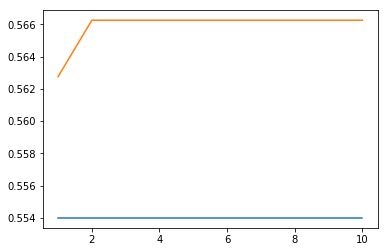

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline

from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix

print(train.groupby('Sentiment')["Sentiment"].count())
print(dev.groupby('Sentiment')["Sentiment"].count())

real = real.cpu().data
pred = pred.cpu().view(len(real)).data #pred.cpu().squeeze(0)
#warning chiante, mais np
cm = ConfusionMatrix(real, pred)
confusion_matrix(real, pred)
print(cm)

import matplotlib.pyplot as plt

plt.plot(range(1,nb_epoch+1), devAcc, range(1,nb_epoch+1), trainAcc)
plt.show()
plt.savefig('acc.png')